# import imprortant library


In [1]:
import numpy as np
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from keras.utils import to_categorical
import torch
import warnings
warnings.filterwarnings('ignore')
import torchvision.models as models
from keras.utils import to_categorical
from sklearn.model_selection import KFold 
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch import optim , autocast
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.cuda.amp import GradScaler
from torchvision import transforms, datasets
from collections import Counter
from torch.optim import AdamW
from sklearn.metrics import confusion_matrix
from torchvision.models import googlenet
from efficientnet_pytorch import EfficientNet
import torch.utils.data as data
%pylab inline


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# load dataset


In [2]:
train_X = torch.load('train_X.pt')
train_Y = torch.load('train_Y.pt')
val_X = torch.load('val_X.pt')
val_Y = torch.load('val_Y.pt')

In [3]:
print("Wafer Tensors Shape:", train_X.shape)
print("Label Tensors Shape:", train_Y.shape)

Wafer Tensors Shape: torch.Size([206397, 3, 56, 56])
Label Tensors Shape: torch.Size([206397, 1, 36])


In [4]:
label = []
train_Y[0].squeeze()
classes = ['C+EL', 'C+EL+L', 'C+EL+S', 'C+ER', 'C+ER+L', 'C+ER+S', 'C+L',
       'C+L+EL+S', 'C+L+ER+S', 'C+L+S', 'C+S', 'Center', 'D+EL', 'D+EL+L',
       'D+EL+S', 'D+ER', 'D+ER+L', 'D+ER+S', 'D+L', 'D+L+EL+S',
       'D+L+ER+S', 'D+L+S', 'D+S', 'Donut', 'EL+L', 'EL+L+S', 'EL+S',
       'ER+L', 'ER+S', 'Edge-Loc', 'Edge-Ring', 'L+S', 'Loc', 'Near-full',
       'Random', 'Scratch']
label_dict = {class_name: i for i, class_name in enumerate(classes)}
label = np.argmax(train_Y.squeeze(), axis=1)

In [5]:
tensor_array = label.numpy()
unique_values, value_counts = np.unique(tensor_array, return_counts=True)

# Sort values by their counts in descending order
sorted_indices = np.argsort(value_counts)[::-1]
sorted_values = unique_values[sorted_indices]
sorted_counts = value_counts[sorted_indices]

# Print or manipulate the sorted values and their counts as needed
print(unique_values)
print(value_counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
[5635 5638 5641 5569 5589 5569 5577 5566 5540 5654 5560 7099 5650 5603
 5509 5600 5647 5595 5564 5661 5593 5628 6740 5607 5578 5634 5574 5654
 5628 5732 5462 6724 6083 5442 5847 6005]


In [6]:
args = {"BATCH_SIZE": 512, "LEARNING_RATE": 0.0008, "NUM_EPOCH": 100}

In [7]:
USE_CUDA = torch.cuda.is_available()
DEVICE = "cuda" if USE_CUDA else "cpu"

In [8]:
class BasicDataset(data.Dataset):
    def __init__(self, x_tensor, y_tensor):
        super(BasicDataset, self).__init__()

        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

In [9]:
dataset_train = BasicDataset(train_X, train_Y)
dataset_val = BasicDataset(val_X, val_Y)
dataset = ConcatDataset([dataset_train, dataset_val])

In [10]:
val_X.shape

torch.Size([88457, 3, 56, 56])

In [18]:
class ResNet(nn.Module):
    def __init__(self, num_classes=36):
        super(ResNet, self).__init__()
        self.resnet  = models.resnet50(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = x.float()
        x = self.resnet(x)
        return x

In [19]:
splits = KFold(n_splits=6, shuffle=True, random_state=42)
foldperf = {}
scaler = GradScaler()
ResNet = ResNet().cuda()
criterion = torch.nn.CrossEntropyLoss().cuda()
optimizer = AdamW(ResNet.parameters(), lr=args["LEARNING_RATE"])
torch.manual_seed(42)

In [20]:
def train_epoch(model, dataloader, loss_fn, optimizer):
    train_loss, train_correct = 0.0, 0
    model.train()
    for images, labels in dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE).reshape(
            args["BATCH_SIZE"], 36
        )
        optimizer.zero_grad()
        with autocast(device_type=DEVICE):
            output = model(images)
            labels = torch.argmax(labels, dim=1)
            loss = loss_fn(output, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        train_loss += loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        train_correct += (predictions == labels).sum().item()
        scaler.update()
    
    return train_loss, train_correct


def valid_epoch(model, dataloader, loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE).reshape(
            args["BATCH_SIZE"], 36
        )
        output = model(images)
        labels = torch.argmax(labels, dim=1)
        loss = loss_fn(output, labels)
        valid_loss += loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        val_correct += (predictions == labels).sum().item()
    return valid_loss, val_correct

In [21]:
for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    
    print("Fold {}".format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(
        dataset, batch_size=args["BATCH_SIZE"], sampler=train_sampler, drop_last=True
    )
    test_loader = DataLoader(
        dataset, batch_size=args["BATCH_SIZE"], sampler=test_sampler, drop_last=True
    )
    history = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}
    # Initialize variables for early stopping
    best_loss = np.inf
    patience = 5
    counter = 0
    
    for epoch in range(args["NUM_EPOCH"]):
        train_loss, train_correct = train_epoch(
            ResNet, train_loader, criterion, optimizer
        )
        test_loss, test_correct = valid_epoch(ResNet, test_loader, criterion)
        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100


        if epoch >= 15:

            if test_loss < best_loss:
                best_loss = test_loss
                counter = 0
            else:
                counter += 1
    
            if counter >= patience:
                print(
                    "Validation loss has not improved for {} epochs. Stopping training...".format(
                        patience
                    )
                )
                break

        print(
            "Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(
                epoch + 1, args["NUM_EPOCH"], train_loss, test_loss, train_acc, test_acc
            )
        )
        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)
        torch.cuda.empty_cache()

    foldperf["fold{}".format(fold + 1)] = history
    

Fold 1
Epoch:1/100 AVG Training Loss:0.299 AVG Test Loss:0.184 AVG Training Acc 89.97 % AVG Test Acc 93.23 %
Epoch:2/100 AVG Training Loss:0.135 AVG Test Loss:0.141 AVG Training Acc 95.62 % AVG Test Acc 94.58 %
Epoch:3/100 AVG Training Loss:0.106 AVG Test Loss:0.115 AVG Training Acc 96.52 % AVG Test Acc 95.45 %
Epoch:4/100 AVG Training Loss:0.090 AVG Test Loss:0.159 AVG Training Acc 97.04 % AVG Test Acc 93.95 %
Epoch:5/100 AVG Training Loss:0.076 AVG Test Loss:0.156 AVG Training Acc 97.41 % AVG Test Acc 94.31 %
Epoch:6/100 AVG Training Loss:0.066 AVG Test Loss:0.136 AVG Training Acc 97.76 % AVG Test Acc 95.01 %
Epoch:7/100 AVG Training Loss:0.057 AVG Test Loss:0.131 AVG Training Acc 98.02 % AVG Test Acc 95.14 %
Epoch:8/100 AVG Training Loss:0.051 AVG Test Loss:0.121 AVG Training Acc 98.18 % AVG Test Acc 95.31 %
Epoch:9/100 AVG Training Loss:0.045 AVG Test Loss:0.124 AVG Training Acc 98.37 % AVG Test Acc 95.62 %
Epoch:10/100 AVG Training Loss:0.040 AVG Test Loss:0.128 AVG Training Acc 9

In [22]:
foldperf

{'fold1': {'train_loss': [0.2991411719332354,
   0.13512380728298617,
   0.10621813989640501,
   0.0895521567819141,
   0.07613242359357693,
   0.06589891292739802,
   0.05700324509720404,
   0.05144673728262094,
   0.04527980236991791,
   0.03988904856087254,
   0.036863183808906685,
   0.032651290849075164,
   0.028319403010227298,
   0.025836476838710345,
   0.024581033032090017,
   0.022625312116403017,
   0.02041263006396714,
   0.017673167996517733,
   0.017282331481936017,
   0.017902251647609745,
   0.016836344983997675,
   0.013718918033629523,
   0.013851401972879658,
   0.013158686752616952],
  'test_loss': [0.18352537258197796,
   0.14115712787390722,
   0.11539522422562466,
   0.15875390059024772,
   0.15628127100082326,
   0.1359074603089036,
   0.13081813275327692,
   0.12136131814311955,
   0.1239339946752027,
   0.1275304219851944,
   0.1380526311711495,
   0.11958049162256557,
   0.1265654445041403,
   0.13459685210563752,
   0.14829946478782813,
   0.1440205799243516

In [23]:
testl_f, tl_f, testa_f, ta_f = [], [], [], []
k = 6
for f in range(1, k + 1):
    tl_f.append(np.mean(foldperf["fold{}".format(f)]["train_loss"]))

    testl_f.append(np.mean(foldperf["fold{}".format(f)]["test_loss"]))

    ta_f.append(np.mean(foldperf["fold{}".format(f)]["train_acc"]))
    testa_f.append(np.mean(foldperf["fold{}".format(f)]["test_acc"]))
    print(
    "Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(
        np.mean(foldperf["fold{}".format(f)]["train_loss"]), np.mean(foldperf["fold{}".format(f)]["test_loss"]),np.mean(foldperf["fold{}".format(f)]["train_acc"]), np.mean(foldperf["fold{}".format(f)]["test_acc"])
    ))

print("Performance of {} fold cross validation".format(k))
print(
    "Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(
        np.mean(tl_f), np.mean(testl_f), np.mean(ta_f), np.mean(testa_f)
    )
)

Average Training Loss: 0.053 	 Average Test Loss: 0.139 	 Average Training Acc: 98.12 	 Average Test Acc: 95.30
Average Training Loss: 0.011 	 Average Test Loss: 0.042 	 Average Training Acc: 99.45 	 Average Test Acc: 97.73
Average Training Loss: 0.007 	 Average Test Loss: 0.025 	 Average Training Acc: 99.60 	 Average Test Acc: 98.23
Average Training Loss: 0.005 	 Average Test Loss: 0.016 	 Average Training Acc: 99.65 	 Average Test Acc: 98.49
Average Training Loss: 0.004 	 Average Test Loss: 0.012 	 Average Training Acc: 99.68 	 Average Test Acc: 98.60
Average Training Loss: 0.004 	 Average Test Loss: 0.011 	 Average Training Acc: 99.70 	 Average Test Acc: 98.64
Performance of 6 fold cross validation
Average Training Loss: 0.014 	 Average Test Loss: 0.041 	 Average Training Acc: 99.37 	 Average Test Acc: 97.83


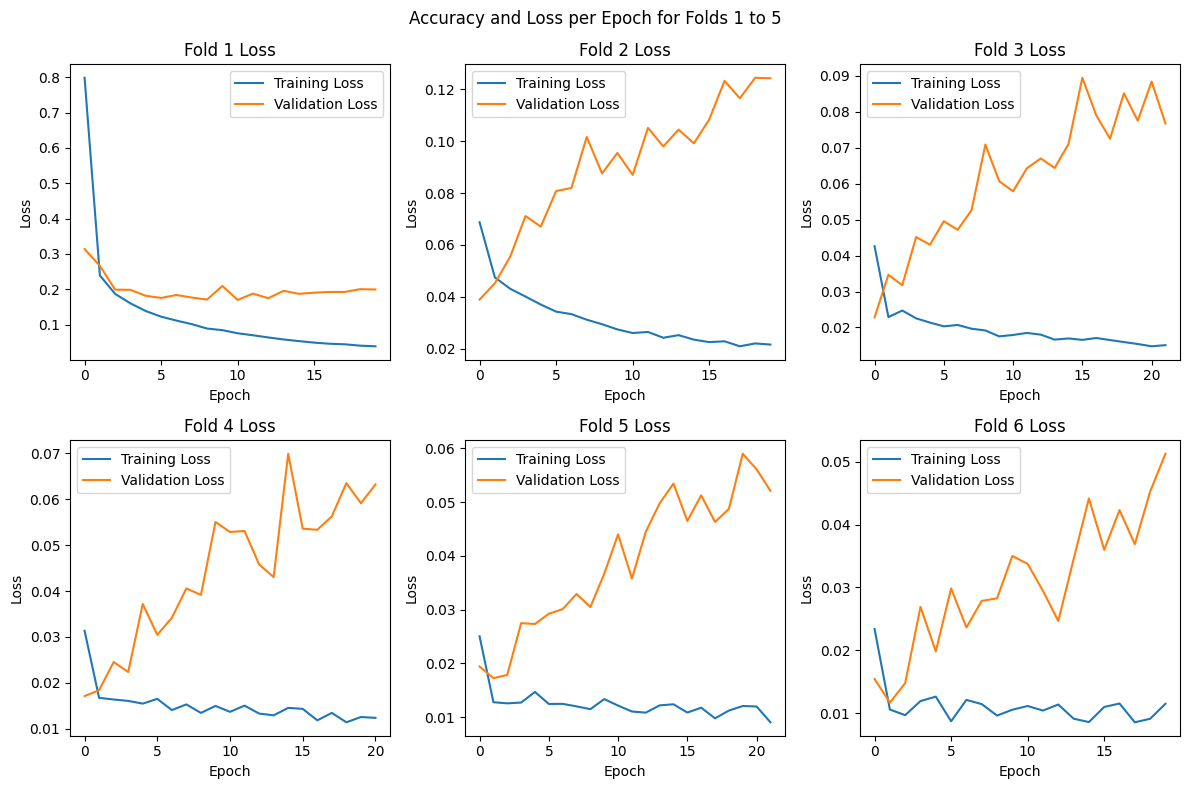

In [25]:
# Determine the number of folds
num_folds = 6  # You can change this to match the actual number of folds

# Create a grid of subplots for each metric (accuracy and loss)
num_rows = 2
num_cols = (num_folds + 1) // 2  # Calculate the number of columns needed based on the number of folds
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
fig.suptitle("Accuracy and Loss per Epoch for Folds 1 to 5")



for fold_number in range(1, num_folds + 1):
    history = foldperf[f"fold{fold_number}"]

    # Calculate the subplot position
    row = (fold_number - 1) // num_cols  # Row number (0 or 1)
    col = (fold_number - 1) % num_cols  # Column number (0 or 1)

    # Plot training and test loss
    axes[row, col].plot(history["train_loss"], label="Training Loss")
    axes[row, col].plot(history["test_loss"], label="Validation Loss")
    axes[row, col].set_xlabel("Epoch")
    axes[row, col].set_ylabel("Loss")
    axes[row, col].set_title(f"Fold {fold_number} Loss")
    axes[row, col].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

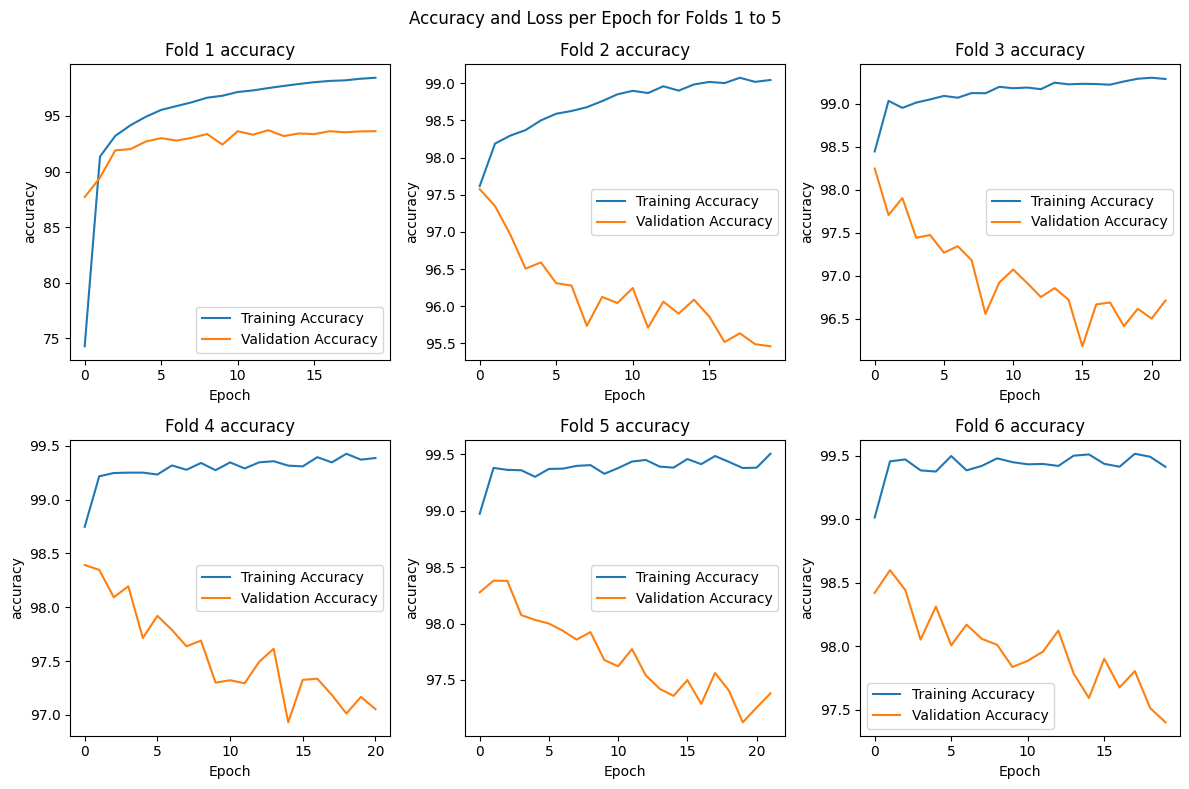

In [26]:
# Determine the number of folds
num_folds = 6  # You can change this to match the actual number of folds

# Create a grid of subplots for each metric (accuracy and loss)
num_rows = 2
num_cols = (num_folds + 1) // 2  # Calculate the number of columns needed based on the number of folds
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
fig.suptitle("Accuracy and Loss per Epoch for Folds 1 to 5")



for fold_number in range(1, num_folds + 1):
    history = foldperf[f"fold{fold_number}"]

    # Calculate the subplot position
    row = (fold_number - 1) // num_cols  # Row number (0 or 1)
    col = (fold_number - 1) % num_cols  # Column number (0 or 1)

    # Plot training and test loss
    axes[row, col].plot(history["train_acc"], label="Training Accuracy")
    axes[row, col].plot(history["test_acc"], label="Validation Accuracy")
    axes[row, col].set_xlabel("Epoch")
    axes[row, col].set_ylabel("accuracy")
    axes[row, col].set_title(f"Fold {fold_number} accuracy")
    axes[row, col].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [28]:
print(history)

{'train_loss': [0.00886108299857154, 0.004592936514387561, 0.004878876692108277, 0.004741748559732661, 0.004057227159226446, 0.004063431895236419, 0.004353157114418268, 0.004387577656168192, 0.005206768645911569, 0.0036244210247075317, 0.0037253263821326764, 0.004079961796430838, 0.004735408088475798, 0.004062171024802514, 0.004757500574610821, 0.0034256795604511374, 0.0038487448509203514, 0.0034167158851681288, 0.0040859902495788926, 0.004132077782451543, 0.004598289995972219, 0.0034271219136768187, 0.004629025590786937], 'test_loss': [0.002991818956681153, 0.013079114172476211, 0.004617018846268183, 0.009135731030653542, 0.009172298577255752, 0.014340669734807616, 0.01531332737675352, 0.01114625687246663, 0.022497377923098603, 0.005610711863935709, 0.010519547854850719, 0.019790373732573936, 0.01851700368413102, 0.025134121819558604, 0.014606869229284633, 0.022198227472558747, 0.023106143762134698, 0.01811756349860188, 0.012709509396814056, 0.024303901276063106, 0.026094720795508643,

In [24]:
torch.save(ResNet.state_dict(), 'ResNet.pth')